# CAO TIẾN TRUNG - 22521553

# **IMPORT MODULE**

In [12]:
import os
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pathlib import Path
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# **LOAD DATA**

In [13]:
DATA_DIR = 'Dataset/MyPedestrian'
data_CLASSNAMES = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]
print(f'Class names: {data_CLASSNAMES}')

Class names: ['NonPedestrian', 'Pedestrian']


In [14]:
# Map class names to indices
def get_class_to_index(directory):
    classes = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    classes.sort()
    return {cls_name: idx for idx, cls_name in enumerate(classes)}

get_class_to_index(DATA_DIR)

{'NonPedestrian': 0, 'Pedestrian': 1}

--------------------------NonPedestrian-------------------------


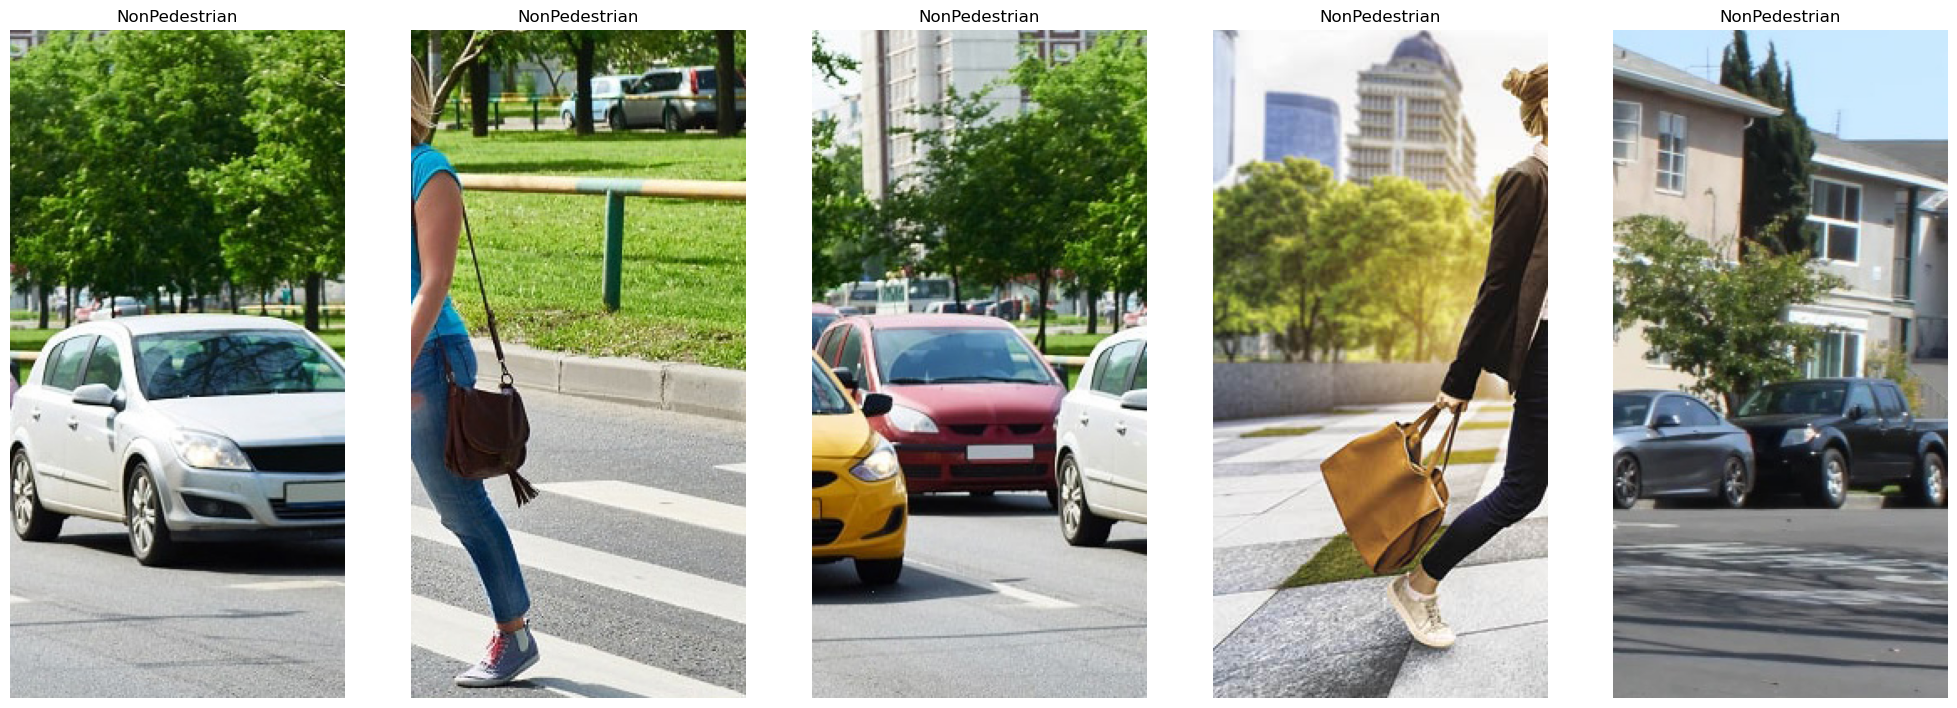

--------------------------Pedestrian-------------------------


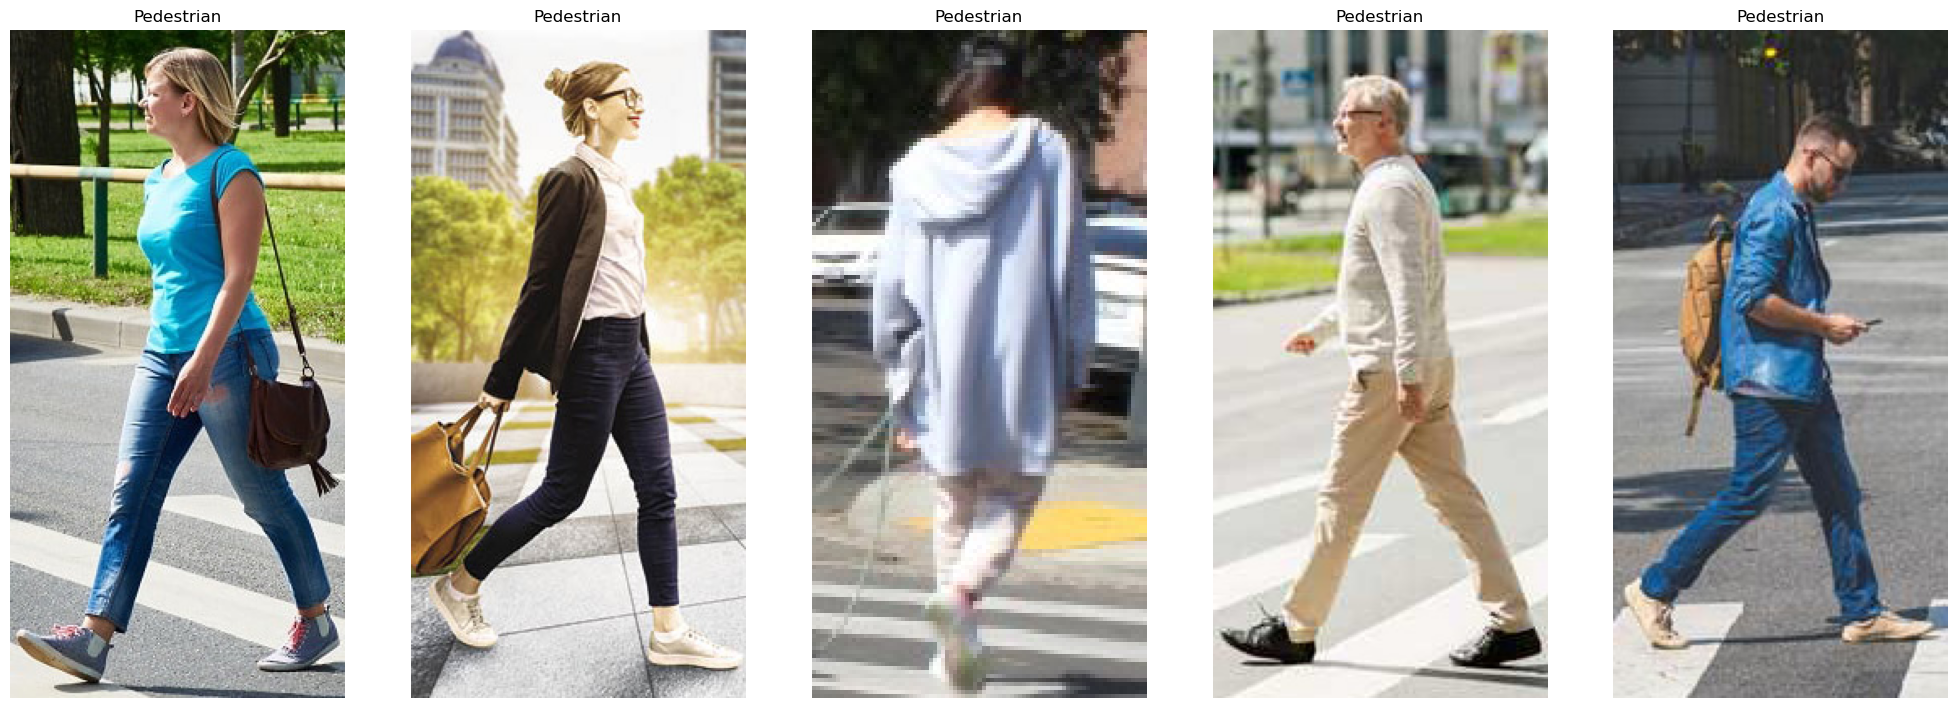

In [15]:
def visualize_dataset(label_path, num):
  plt.figure(figsize=(25,10))
  for i, image_path in enumerate(sorted(os.listdir(label_path))[:num]):
      plt.subplot(math.ceil(num/5), 5, i+1)
      image = cv2.imread(os.path.join(label_path, image_path))
      if image is None:
        print(f"ERROR: Không thể đọc ảnh {image_path}")
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      plt.imshow(image)
      plt.title(Path(label_path).name)
      plt.axis("off")
  plt.show()

for label in data_CLASSNAMES:
  print(f'--------------------------{label}-------------------------')
  label_path = os.path.join(DATA_DIR, label)
  visualize_dataset(label_path=label_path,
                    num=5)


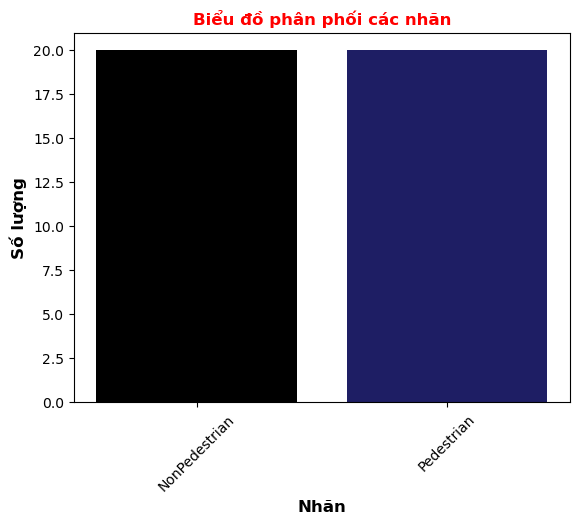

In [16]:
colors = cm.CMRmap([i / 10 for i in range(10)])

labels = dict()
for label in data_CLASSNAMES:
    labels[label] = len(os.listdir(os.path.join(DATA_DIR, label)))

plt.bar(labels.keys(), labels.values(), color = colors)
plt.title('Biểu đồ phân phối các nhãn', fontweight ='bold', fontsize = 12, color = 'red')
plt.xlabel('Nhãn', fontweight ='bold', fontsize = 12)
plt.ylabel('Số lượng', fontweight ='bold', fontsize = 12)
plt.xticks(rotation=45)
plt.show()

# **EXTRACT FEATURE WITH HOG**

In [17]:
IMG_WIDTH = 128
IMG_HEIGHT = 256

HOG_PARAMS = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'block_norm': 'L2-Hys',
    'feature_vector': True
}

def extractHOGFeature(img):
    return hog(img, **HOG_PARAMS)

def load_data_from_directory(directory):
    class_to_index = get_class_to_index(directory)
    features = []
    labels = []
    paths = []
    for root, _, files in os.walk(directory):
        if root == directory:
            continue
        for fname in files:
            if not fname.lower().endswith(('png', 'jpg')):
                continue
            path = os.path.join(root, fname)
            folder = os.path.basename(root)
            label = class_to_index.get(folder)

            img_color = cv2.imread(path)
            if img_color is None:
                continue
            img = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
            # Resize image
            img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            # Extract HOG features
            hog_feature = extractHOGFeature(img_resized)
            features.append(hog_feature)
            labels.append(label)
            paths.append(path)
    return np.array(features), np.array(labels), paths

# **MODELLING**

## **Train test split**

In [18]:
X, y, paths = load_data_from_directory(DATA_DIR)
X_train, X_test, y_train, y_test, paths_train, paths_test = train_test_split(
    X, y, paths,
    test_size=0.3,
    random_state=42,
    stratify=y
)

## **KNN**

Accuracy: 0.7500
F1-score: 0.7333
Precision: 0.8333
Recall: 0.7500
               precision    recall  f1-score   support

NonPedestrian       0.67      1.00      0.80         6
   Pedestrian       1.00      0.50      0.67         6

     accuracy                           0.75        12
    macro avg       0.83      0.75      0.73        12
 weighted avg       0.83      0.75      0.73        12

Confusion Matrix:


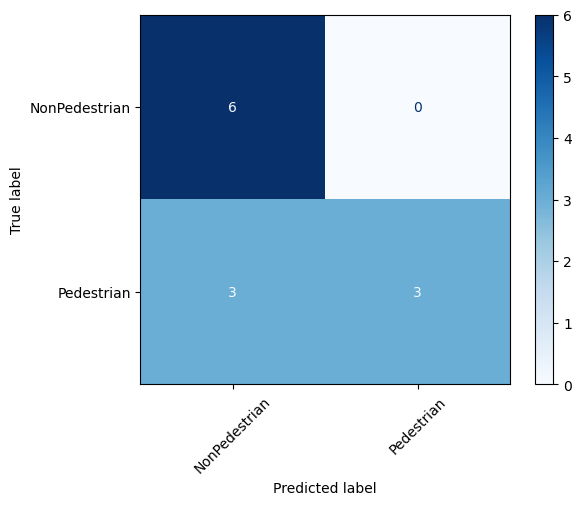

In [19]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_knn)
f1 = f1_score(y_test, y_pred_knn, average='macro')
precision = precision_score(y_test, y_pred_knn, average='macro')
recall = recall_score(y_test, y_pred_knn, average='macro')
conf_matrix = confusion_matrix(y_test, y_pred_knn)

print(f'Accuracy: {accuracy:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
class_labels = list(get_class_to_index(DATA_DIR).keys())
print(classification_report(y_test, y_pred_knn,
                              target_names=class_labels))
print('Confusion Matrix:')
conf_matrix = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)



#### *Visualize wrong samples*

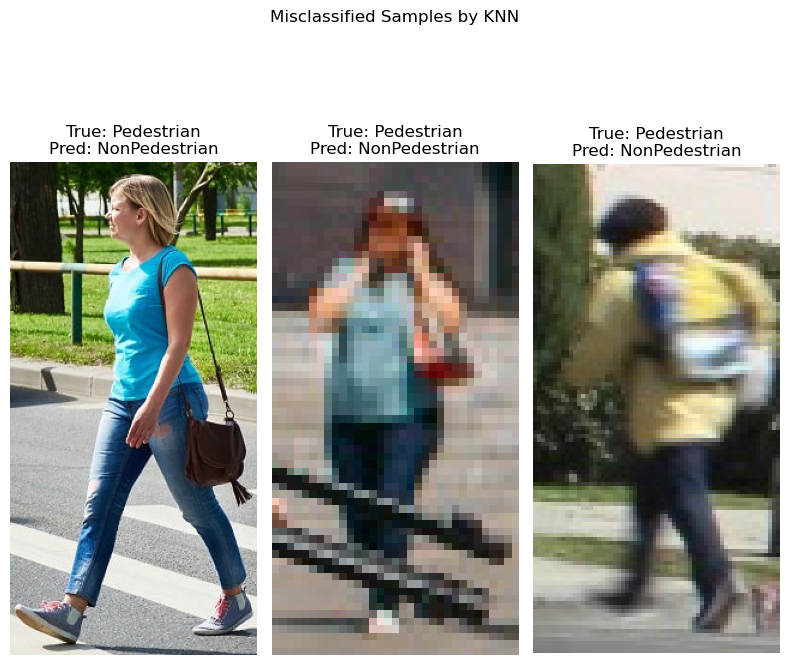

In [20]:
mis_idx = [i for i, (true, pred) in enumerate(zip(y_test, y_pred_knn)) if true != pred]
plt.figure(figsize=(8, 8))
for i in range(len(mis_idx)):
    idx = mis_idx[i]
    img = cv2.imread(paths_test[idx])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(math.ceil(len(mis_idx)/3), 3, i+1)
    plt.imshow(img_rgb)
    plt.title(f"True: {list(get_class_to_index(DATA_DIR).keys())[y_test[idx]]}\nPred: {list(get_class_to_index(DATA_DIR).keys())[y_pred_knn[idx]]}")
    plt.axis('off')
plt.suptitle('Misclassified Samples by KNN')
plt.tight_layout()
plt.show()


## **Logistic Regression**

Accuracy: 1.0000
F1-score: 1.0000
Precision: 1.0000
Recall: 1.0000
               precision    recall  f1-score   support

NonPedestrian       1.00      1.00      1.00         6
   Pedestrian       1.00      1.00      1.00         6

     accuracy                           1.00        12
    macro avg       1.00      1.00      1.00        12
 weighted avg       1.00      1.00      1.00        12

Confusion Matrix:


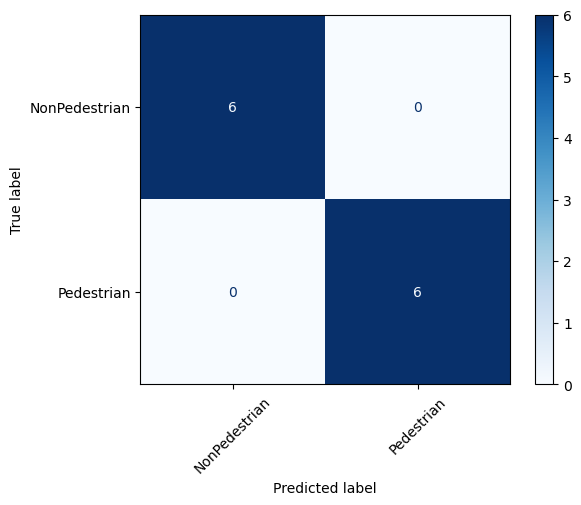

In [21]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr, average='macro')
precision = precision_score(y_test, y_pred_lr, average='macro')
recall = recall_score(y_test, y_pred_lr, average='macro')
conf_matrix = confusion_matrix(y_test, y_pred_lr)

print(f'Accuracy: {accuracy:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
class_labels = list(get_class_to_index(DATA_DIR).keys())
print(classification_report(y_test, y_pred_lr,
                              target_names=class_labels))
print('Confusion Matrix:')
conf_matrix = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)

#### *Visualize wrong samples*

In [22]:
mis_idx = [i for i, (true, pred) in enumerate(zip(y_test, y_pred_lr)) if true != pred]
plt.figure(figsize=(8, 8))
for i in range(len(mis_idx)):
    idx = mis_idx[i]
    img = cv2.imread(paths_test[idx])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(math.ceil(len(mis_idx)/3), 3, i+1)
    plt.imshow(img_rgb)
    plt.title(f"True: {list(get_class_to_index(DATA_DIR).keys())[y_test[idx]]}\nPred: {list(get_class_to_index(DATA_DIR).keys())[y_pred_lr[idx]]}")
    plt.axis('off')
plt.suptitle('Misclassified Samples by Logistic Regression')
plt.tight_layout()
plt.show()

<Figure size 800x800 with 0 Axes>